<a href="https://colab.research.google.com/github/redrum88/tensorflow/blob/main/10_time_series_forecasting_with_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not financial advice.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code/text: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

## Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-06 20:16:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2023-03-06 20:16:46 (15.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We've collected the historical price of Bitcoin for the past 8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples.

A smaller number of samples is something you'll often run into  with time series data problems. 

> 🔑 **Note:** The **seasonality** of time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.



In [4]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


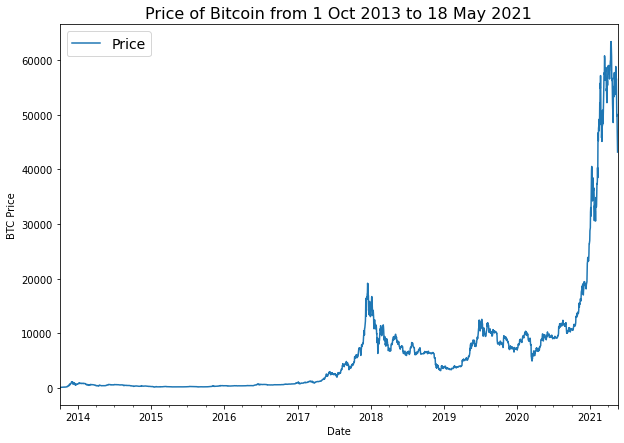

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [6]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime
timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

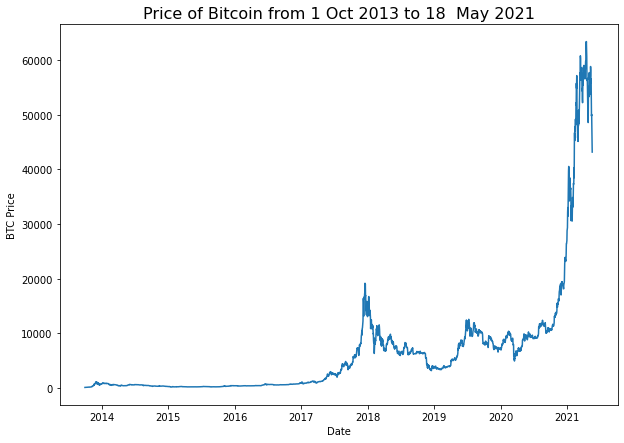

In [7]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps,
         btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18  May 2021", fontsize=16)
plt.xlabel("Date");


## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [8]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [9]:
# Wrong way to make train/test sets for timeseries data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

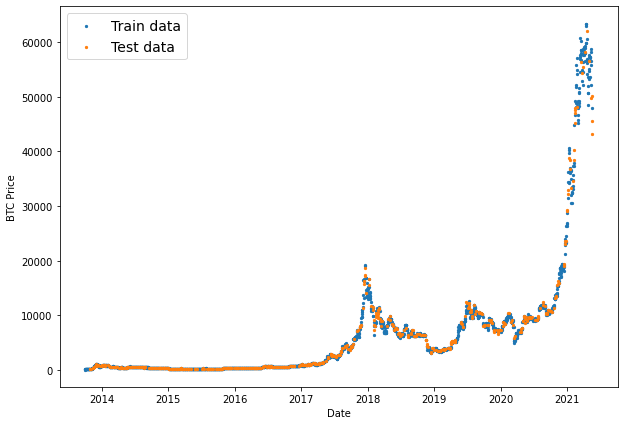

In [10]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)


In [11]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

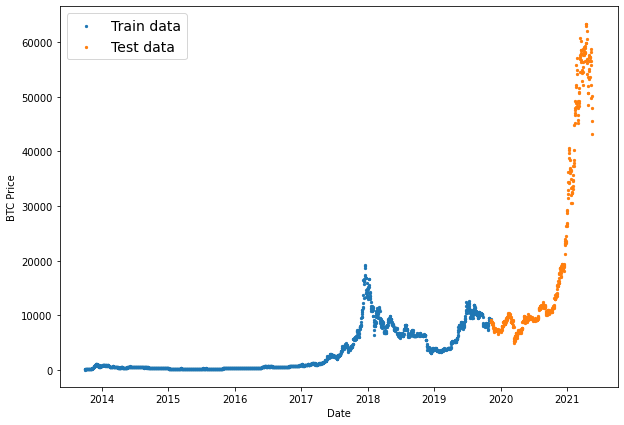

In [12]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [13]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

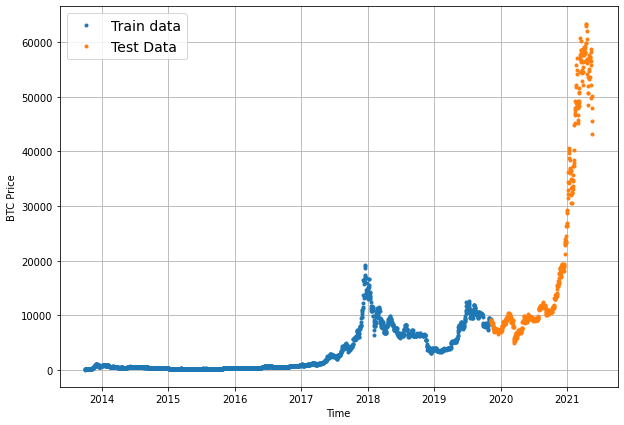

In [14]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict horizon

Modelling experiments we're running:
* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey 🦃 data introduced)


## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [15]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

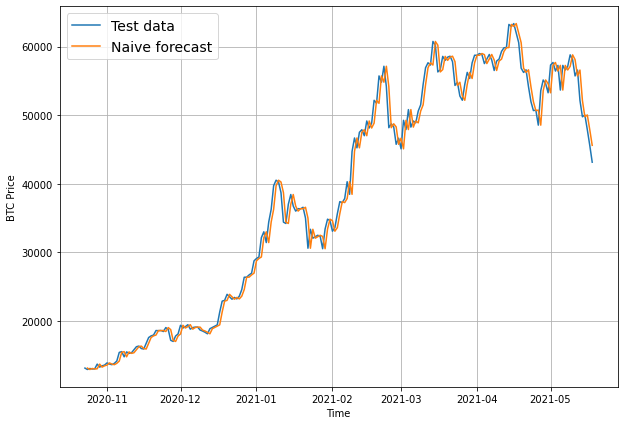

In [16]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")

> ⚒️ **Exercise:** Spend 10 minutes reading the simple forecasts chapter of Forecasting: Principles in Practice. An have a search to find out why the naive forecast is hard to beat, does the term augoregressive come up?

from IPython.core.magic import error
## Evaluating a time series model

Let's take into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that mean we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RSME - root mean suare error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
+ MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than a MAE of 100.

The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [17]:
import tensorflow as tf

In [18]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Calculates the mean absolute scaled error (MASE) between true and predicted values.

  The MASE measures the relative performance of a forecasting model compared to a naive (naïve2) forecast.
  The MASE is a scaling factor that scales the mean absolute error (MAE) of the forecast to account for the scale
  of the data and the forecast horizon. A MASE of 1 indicates that the forecasting model performs as well as a
  naive forecast, while a MASE < 1 indicates that the model outperforms the naive forecast.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A scalar value representing the MASE between y_true and y_pred.
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day, hence the shift of 1

  return mae / mae_naive_no_season

In [19]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [20]:
# Create a function to evaluate model forecasts with various metrics
def evaluate_preds(y_true, y_pred):
  """
  Evaluates model predictions with various metrics.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A dictionary of evaluation metrics, including:
          - 'mae': mean absolute error
          - 'mse': mean squared error
          - 'rmse': root mean squared error
          - 'mape': mean absolute percentage error
          - 'mase': mean absolute scaled error
  """
  # Make sure float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [21]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [22]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [23]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [24]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [25]:
len(y_train)

2229

In [26]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [27]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use past week of Bitcoin data to make the prediction


In [28]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
    Given a data matrix 'x', return a pair of matrices containing labelled and windowed segments of the data.

    Parameters:
        - x (ndarray): A 2-dimensional matrix of shape (T, D), where T is the number of timesteps and
          D is the number of dimensions.
        - horizon (int): The number of timesteps to include in the window.
        
    Returns:
        - A tuple containing two 2-dimensional matrices of shape (T - horizon, horizon) and (T - horizon, 1),
          respectively. The first matrix contains the windowed segments of the input data, and the second matrix
          contains the labels that correspond to each window.
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 5, 6],
[1, 2, 3, 5, 6, 7],
[2, 3, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

In [30]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Creates windowed data from a target time series.

  Parameters:
      - x (ndarray): A 1-dimensional array containing the target time series.
      - window_size (int): The size of the window to use to create the data (default: WINDOW_SIZE).
      - horizon (int): The number of timesteps into the future to predict (default: HORIZON).

  Returns:
      - A tuple containing two 2-dimensional arrays of shape (N, window_size) and (N, horizon),
        respectively. The first array contains the windowed segments of the input data, and the
        second array contains the labels that correspond to each window.

  Example usage:
  ```python
  # Load some example data
  target_series = np.loadtxt('target_series.txt')

  # Create windowed data with a window size of 30 and a horizon of 1
  X, y = make_windows(target_series, window_size=30, horizon=1)
  ```
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (a time series) with 2D araay of multiple window steps
  windowed_array = x[window_indexes]
  
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [32]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [33]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [34]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.

  Parameters:
       - windows (ndarray): A 2-dimensional matrix of shape (N, W), where N is the number of windows
        and W is the window size.
      - labels (ndarray): A 2-dimensional matrix of shape (N, H), where N is the number of windows
        and H is the horizon (i.e. the number of timesteps to predict into the future).
      - test_split (float): The proportion of data to allocate for the test split. Defaults to 0.2.

  Returns:
      - A tuple containing four 2-dimensional matrices: (train_windows, test_windows, train_labels, test_labels).
        The training windows and labels are the first two elements of the tuple and represent the training split of
        the input data, while the test windows and labels are the last two elements of the tuple and represent the
        test split of the input data.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [35]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [36]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [37]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [38]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [39]:
import os

# Create a function to implement a modelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  """
  Creates a Keras callback to save the best version of a trained model during training.

  Args:
      model_name (str): A string with the name of the model. This will be used as the prefix of the checkpoint file.
      save_path (str): A string with the directory path where the checkpoint file will be saved. Defaults to "model_experiments".

  Returns:
      A Keras `ModelCheckpoint` callback instance with the specified settings.
  """
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)


## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.

* *Hyperparameters* = values a machine learning practitioner can adjust themselves
* **Parameters** = values a model learns on its own


In [40]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1_history = model_1.fit(train_windows, train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 701.0253 - mae: 701.0253 - mse: 1949751.0000    

18/18 [==============================] - 6s 60ms/step - loss: 667.3416 - mae: 667.3416 - mse: 1815225.5000 - val_loss: 1086.0598 - val_mae: 1086.0598 - val_mse: 3928092.5000
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 244.7298 - mae: 244.7298 - mse: 254639.9062

18/18 [==============================] - 1s 38ms/step - loss: 242.8000 - mae: 242.8000 - mse: 250989.4688 - val_loss: 1083.4135 - val_mae: 1083.4135 - val_mse: 3927198.7500
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 196.3284 - mae: 196.3284 - mse: 197147.7969 - val_loss: 1181.3795 - val_mae: 1181.3795 - val_mse: 4011284.7500
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 185.8020 - mae: 185.8020 - mse: 183112.7031

18/18 [==============================] - 1s 39ms/step - loss: 183.9527 - mae: 183.9527 - mse: 180077.7188 - val_loss: 1016.6204 - val_mae: 1016.6204 - val_mse: 3340731.2500
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 177.6606 - mae: 177.6606 - mse: 169909.5156

18/18 [==============================] - 1s 47ms/step - loss: 177.6606 - mae: 177.6606 - mse: 169909.5156 - val_loss: 962.8102 - val_mae: 962.8102 - val_mse: 3055299.7500
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 168.5098 - mae: 168.5098 - mse: 144951.7188

18/18 [==============================] - 1s 39ms/step - loss: 170.2621 - mae: 170.2621 - mse: 155111.1719 - val_loss: 942.5968 - val_mae: 942.5968 - val_mse: 2829569.7500
Epoch 7/100
18/18 [==============================] - ETA: 0s - loss: 162.4306 - mae: 162.4306 - mse: 144023.6406

18/18 [==============================] - 1s 36ms/step - loss: 162.4306 - mae: 162.4306 - mse: 144023.6406 - val_loss: 896.2328 - val_mae: 896.2328 - val_mse: 2625159.2500
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 158.2927 - mae: 158.2927 - mse: 136452.9531

18/18 [==============================] - 1s 38ms/step - loss: 158.2927 - mae: 158.2927 - mse: 136452.9531 - val_loss: 883.7137 - val_mae: 883.7137 - val_mse: 2616636.2500
Epoch 9/100
17/18 [===========================>..] - ETA: 0s - loss: 156.6758 - mae: 156.6758 - mse: 134428.4531

18/18 [==============================] - 1s 44ms/step - loss: 156.5956 - mae: 156.5956 - mse: 133279.9375 - val_loss: 840.6327 - val_mae: 840.6327 - val_mse: 2356376.7500
Epoch 10/100
12/18 [===================>..........] - ETA: 0s - loss: 144.9241 - mae: 144.9241 - mse: 108730.1797

18/18 [==============================] - 1s 56ms/step - loss: 151.3878 - mae: 151.3878 - mse: 127967.2344 - val_loss: 819.1176 - val_mae: 819.1176 - val_mse: 2225002.2500
Epoch 11/100
18/18 [==============================] - 0s 8ms/step - loss: 145.1488 - mae: 145.1488 - mse: 117676.3828 - val_loss: 832.1570 - val_mae: 832.1570 - val_mse: 2173986.5000
Epoch 12/100
18/18 [==============================] - 0s 8ms/step - loss: 142.3417 - mae: 142.3417 - mse: 113199.4219 - val_loss: 833.0511 - val_mae: 833.0511 - val_mse: 2130165.2500
Epoch 13/100
18/18 [==============================] - 0s 8ms/step - loss: 143.0773 - mae: 143.0773 - mse: 111793.7656 - val_loss: 819.1537 - val_mae: 819.1537 - val_mse: 2057108.5000
Epoch 14/100
14/18 [======================>.......] - ETA: 0s - loss: 136.9220 - mae: 136.9220 - mse: 106510.8750

18/18 [==============================] - 1s 50ms/step - loss: 137.3502 - mae: 137.3502 - mse: 106806.4844 - val_loss: 779.1823 - val_mae: 779.1823 - val_mse: 1911629.3750
Epoch 15/100
15/18 [========================>.....] - ETA: 0s - loss: 140.8210 - mae: 140.8210 - mse: 110249.3750

18/18 [==============================] - 1s 36ms/step - loss: 138.6315 - mae: 138.6315 - mse: 104811.4062 - val_loss: 738.2391 - val_mae: 738.2391 - val_mse: 1807135.5000
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 131.9305 - mae: 131.9305 - mse: 99394.0469

18/18 [==============================] - 1s 37ms/step - loss: 130.5019 - mae: 130.5019 - mse: 97720.1016 - val_loss: 731.1694 - val_mae: 731.1694 - val_mse: 1740937.7500
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 129.3198 - mae: 129.3198 - mse: 97711.5938 - val_loss: 742.6655 - val_mae: 742.6655 - val_mse: 1740606.3750
Epoch 18/100
18/18 [==============================] - ETA: 0s - loss: 127.7900 - mae: 127.7900 - mse: 94664.2188 

18/18 [==============================] - 1s 38ms/step - loss: 127.7900 - mae: 127.7900 - mse: 94664.2188 - val_loss: 702.2242 - val_mae: 702.2242 - val_mse: 1662668.3750
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 126.7757 - mae: 126.7757 - mse: 93674.9297 - val_loss: 733.5811 - val_mae: 733.5811 - val_mse: 1682238.7500
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 123.6567 - mae: 123.6567 - mse: 89462.7734 

18/18 [==============================] - 1s 35ms/step - loss: 123.6567 - mae: 123.6567 - mse: 89462.7734 - val_loss: 685.2482 - val_mae: 685.2482 - val_mse: 1567721.6250
Epoch 21/100
16/18 [=========================>....] - ETA: 0s - loss: 125.8519 - mae: 125.8519 - mse: 88779.9922

18/18 [==============================] - 1s 37ms/step - loss: 126.3736 - mae: 126.3736 - mse: 91211.2656 - val_loss: 675.9442 - val_mae: 675.9442 - val_mse: 1560773.3750
Epoch 22/100
18/18 [==============================] - 0s 6ms/step - loss: 124.3451 - mae: 124.3451 - mse: 89986.2578 - val_loss: 679.8989 - val_mae: 679.8989 - val_mse: 1518278.8750
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 122.6400 - mae: 122.6400 - mse: 82977.2734

18/18 [==============================] - 1s 38ms/step - loss: 123.5873 - mae: 123.5873 - mse: 86984.2812 - val_loss: 662.4466 - val_mae: 662.4466 - val_mse: 1498748.3750
Epoch 24/100
17/18 [===========================>..] - ETA: 0s - loss: 121.8750 - mae: 121.8750 - mse: 88593.4688

18/18 [==============================] - 1s 40ms/step - loss: 120.4228 - mae: 120.4228 - mse: 87037.6797 - val_loss: 659.1841 - val_mae: 659.1841 - val_mse: 1460849.3750
Epoch 25/100
17/18 [===========================>..] - ETA: 0s - loss: 119.1116 - mae: 119.1116 - mse: 84471.2031

18/18 [==============================] - 1s 37ms/step - loss: 118.5287 - mae: 118.5287 - mse: 83545.1328 - val_loss: 650.4664 - val_mae: 650.4664 - val_mse: 1455015.8750
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 121.7520 - mae: 121.7520 - mse: 83992.7656

18/18 [==============================] - 1s 51ms/step - loss: 120.2022 - mae: 120.2022 - mse: 84480.3047 - val_loss: 645.3830 - val_mae: 645.3830 - val_mse: 1416758.1250
Epoch 27/100
17/18 [===========================>..] - ETA: 0s - loss: 119.4046 - mae: 119.4046 - mse: 80227.8750 

18/18 [==============================] - 1s 37ms/step - loss: 119.8187 - mae: 119.8187 - mse: 82423.8594 - val_loss: 641.9546 - val_mae: 641.9546 - val_mse: 1425986.1250
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 116.4579 - mae: 116.4579 - mse: 82116.8984

18/18 [==============================] - 1s 36ms/step - loss: 116.3395 - mae: 116.3395 - mse: 81156.8594 - val_loss: 638.4769 - val_mae: 638.4769 - val_mse: 1386518.5000
Epoch 29/100
18/18 [==============================] - ETA: 0s - loss: 120.5443 - mae: 120.5443 - mse: 83041.5078

18/18 [==============================] - 1s 40ms/step - loss: 120.5443 - mae: 120.5443 - mse: 83041.5078 - val_loss: 631.0636 - val_mae: 631.0636 - val_mse: 1378424.1250
Epoch 30/100
16/18 [=========================>....] - ETA: 0s - loss: 118.8495 - mae: 118.8495 - mse: 79799.8906 

18/18 [==============================] - 1s 38ms/step - loss: 120.0401 - mae: 120.0401 - mse: 82398.8594 - val_loss: 628.2900 - val_mae: 628.2900 - val_mse: 1368836.1250
Epoch 31/100
17/18 [===========================>..] - ETA: 0s - loss: 113.4870 - mae: 113.4870 - mse: 77262.3672

18/18 [==============================] - 1s 37ms/step - loss: 114.2187 - mae: 114.2187 - mse: 77976.5312 - val_loss: 626.5963 - val_mae: 626.5963 - val_mse: 1347241.7500
Epoch 32/100
18/18 [==============================] - 0s 6ms/step - loss: 115.6390 - mae: 115.6390 - mse: 80233.9531 - val_loss: 628.5103 - val_mae: 628.5103 - val_mse: 1345145.3750
Epoch 33/100
18/18 [==============================] - 0s 9ms/step - loss: 115.3203 - mae: 115.3203 - mse: 77721.8672 - val_loss: 652.2422 - val_mae: 652.2422 - val_mse: 1391019.2500
Epoch 34/100
11/18 [=================>............] - ETA: 0s - loss: 121.2156 - mae: 121.2156 - mse: 92967.0391 

18/18 [==============================] - 1s 56ms/step - loss: 114.5744 - mae: 114.5744 - mse: 79728.9375 - val_loss: 624.3171 - val_mae: 624.3171 - val_mse: 1363482.8750
Epoch 35/100
12/18 [===================>..........] - ETA: 0s - loss: 114.6102 - mae: 114.6102 - mse: 78610.4297

18/18 [==============================] - 1s 57ms/step - loss: 113.8685 - mae: 113.8685 - mse: 78939.3750 - val_loss: 610.6268 - val_mae: 610.6268 - val_mse: 1302863.1250
Epoch 36/100
18/18 [==============================] - 0s 8ms/step - loss: 115.9041 - mae: 115.9041 - mse: 77302.0000 - val_loss: 615.7307 - val_mae: 615.7307 - val_mse: 1333580.3750
Epoch 37/100
11/18 [=================>............] - ETA: 0s - loss: 114.0281 - mae: 114.0281 - mse: 80655.3359 

18/18 [==============================] - 1s 41ms/step - loss: 112.8486 - mae: 112.8486 - mse: 77764.0625 - val_loss: 607.6478 - val_mae: 607.6478 - val_mse: 1300872.6250
Epoch 38/100
16/18 [=========================>....] - ETA: 0s - loss: 112.3307 - mae: 112.3307 - mse: 76567.3984

18/18 [==============================] - 1s 38ms/step - loss: 112.4701 - mae: 112.4701 - mse: 77318.2266 - val_loss: 604.0884 - val_mae: 604.0884 - val_mse: 1278971.0000
Epoch 39/100
17/18 [===========================>..] - ETA: 0s - loss: 111.8619 - mae: 111.8619 - mse: 76890.2031 

18/18 [==============================] - 1s 37ms/step - loss: 112.4759 - mae: 112.4759 - mse: 77527.5234 - val_loss: 600.7278 - val_mae: 600.7278 - val_mse: 1277155.8750
Epoch 40/100
18/18 [==============================] - ETA: 0s - loss: 110.4754 - mae: 110.4754 - mse: 75090.4062

18/18 [==============================] - 1s 39ms/step - loss: 110.4754 - mae: 110.4754 - mse: 75090.4062 - val_loss: 599.8132 - val_mae: 599.8132 - val_mse: 1275644.2500
Epoch 41/100
16/18 [=========================>....] - ETA: 0s - loss: 113.0084 - mae: 113.0084 - mse: 76818.7031

18/18 [==============================] - 1s 49ms/step - loss: 111.3149 - mae: 111.3149 - mse: 73808.8047 - val_loss: 597.4504 - val_mae: 597.4504 - val_mse: 1258386.5000
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 113.5704 - mae: 113.5704 - mse: 77401.8359 - val_loss: 722.1884 - val_mae: 722.1884 - val_mse: 1537416.3750
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 118.7898 - mae: 118.7898 - mse: 76380.1250 - val_loss: 699.4391 - val_mae: 699.4391 - val_mse: 1552427.1250
Epoch 44/100
18/18 [==============================] - 0s 7ms/step - loss: 114.3888 - mae: 114.3888 - mse: 74605.2812 - val_loss: 606.3892 - val_mae: 606.3892 - val_mse: 1266530.1250
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 111.0470 - mae: 111.0470 - mse: 73376.6016 - val_loss: 604.7151 - val_mae: 604.7151 - val_mse: 1288509.8750
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 110.2610 - mae: 110.2610 - m

18/18 [==============================] - 1s 36ms/step - loss: 109.0887 - mae: 109.0887 - mse: 72800.6484 - val_loss: 591.0703 - val_mae: 591.0703 - val_mse: 1232613.7500
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 112.1108 - mae: 112.1108 - mse: 75358.4922 - val_loss: 712.4213 - val_mae: 712.4213 - val_mse: 1503556.2500
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 120.4650 - mae: 120.4650 - mse: 79146.8047 - val_loss: 641.1346 - val_mae: 641.1346 - val_mse: 1371118.1250
Epoch 51/100
17/18 [===========================>..] - ETA: 0s - loss: 112.8080 - mae: 112.8080 - mse: 74295.8594

18/18 [==============================] - 1s 36ms/step - loss: 112.7179 - mae: 112.7179 - mse: 73696.8594 - val_loss: 589.7219 - val_mae: 589.7219 - val_mse: 1226541.8750
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 114.4311 - mae: 114.4311 - mse: 75651.0938 - val_loss: 618.0992 - val_mae: 618.0992 - val_mse: 1311419.8750
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 111.6410 - mae: 111.6410 - mse: 73144.6797 - val_loss: 624.0428 - val_mae: 624.0428 - val_mse: 1289133.8750
Epoch 54/100
17/18 [===========================>..] - ETA: 0s - loss: 111.2719 - mae: 111.2719 - mse: 74086.9375

18/18 [==============================] - 1s 36ms/step - loss: 111.1272 - mae: 111.1272 - mse: 73321.3047 - val_loss: 589.2000 - val_mae: 589.2000 - val_mse: 1221209.2500
Epoch 55/100
14/18 [======================>.......] - ETA: 0s - loss: 113.0419 - mae: 113.0419 - mse: 77236.0156 

18/18 [==============================] - 1s 37ms/step - loss: 108.3957 - mae: 108.3957 - mse: 72677.2656 - val_loss: 585.6996 - val_mae: 585.6996 - val_mse: 1214439.1250
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 108.7504 - mae: 108.7504 - mse: 71651.0391 - val_loss: 728.6163 - val_mae: 728.6163 - val_mse: 1615079.5000
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 114.0033 - mae: 114.0033 - mse: 75173.7656 - val_loss: 627.4775 - val_mae: 627.4775 - val_mse: 1292248.8750
Epoch 58/100
17/18 [===========================>..] - ETA: 0s - loss: 107.3990 - mae: 107.3990 - mse: 69919.6250

18/18 [==============================] - 1s 37ms/step - loss: 108.0689 - mae: 108.0689 - mse: 71814.2656 - val_loss: 584.8160 - val_mae: 584.8160 - val_mse: 1224947.1250
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 106.9392 - mae: 106.9392 - mse: 70845.2969 - val_loss: 608.6271 - val_mae: 608.6271 - val_mse: 1280069.7500
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 111.7728 - mae: 111.7728 - mse: 75207.7500 - val_loss: 644.3626 - val_mae: 644.3626 - val_mse: 1326895.0000
Epoch 61/100
17/18 [===========================>..] - ETA: 0s - loss: 113.5900 - mae: 113.5900 - mse: 76587.7188

18/18 [==============================] - 1s 38ms/step - loss: 112.3500 - mae: 112.3500 - mse: 75250.5469 - val_loss: 578.1595 - val_mae: 578.1595 - val_mse: 1204436.7500
Epoch 62/100
16/18 [=========================>....] - ETA: 0s - loss: 107.9254 - mae: 107.9254 - mse: 71750.3047

18/18 [==============================] - 1s 37ms/step - loss: 106.1851 - mae: 106.1851 - mse: 69793.5703 - val_loss: 576.5593 - val_mae: 576.5593 - val_mse: 1193834.6250
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 107.0894 - mae: 107.0894 - mse: 70308.7969 - val_loss: 576.7119 - val_mae: 576.7119 - val_mse: 1192476.2500
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 106.8030 - mae: 106.8030 - mse: 70459.9688 - val_loss: 629.0236 - val_mae: 629.0236 - val_mse: 1293441.8750
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 111.1395 - mae: 111.1395 - mse: 73574.9922 - val_loss: 578.6584 - val_mae: 578.6584 - val_mse: 1204152.7500
Epoch 66/100
15/18 [========================>.....] - ETA: 0s - loss: 107.4791 - mae: 107.4791 - mse: 71283.6484

18/18 [==============================] - 1s 59ms/step - loss: 107.2877 - mae: 107.2877 - mse: 70735.2578 - val_loss: 575.6470 - val_mae: 575.6470 - val_mse: 1194156.3750
Epoch 67/100
18/18 [==============================] - 0s 9ms/step - loss: 107.7327 - mae: 107.7327 - mse: 69769.8750 - val_loss: 644.3729 - val_mae: 644.3729 - val_mse: 1356894.1250
Epoch 68/100
18/18 [==============================] - 0s 8ms/step - loss: 112.4004 - mae: 112.4004 - mse: 70729.6484 - val_loss: 622.1770 - val_mae: 622.1770 - val_mse: 1302716.3750
Epoch 69/100
18/18 [==============================] - 0s 8ms/step - loss: 118.7348 - mae: 118.7348 - mse: 75782.3438 - val_loss: 757.2106 - val_mae: 757.2106 - val_mse: 1622437.2500
Epoch 70/100
18/18 [==============================] - 0s 8ms/step - loss: 124.7746 - mae: 124.7746 - mse: 79546.0391 - val_loss: 578.5051 - val_mae: 578.5051 - val_mse: 1200716.5000
Epoch 71/100
18/18 [==============================] - 0s 8ms/step - loss: 106.7549 - mae: 106.7549 - m

18/18 [==============================] - 1s 36ms/step - loss: 108.3194 - mae: 108.3194 - mse: 70880.2031 - val_loss: 571.7391 - val_mae: 571.7391 - val_mse: 1178841.0000
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 106.4459 - mae: 106.4459 - mse: 70058.6406 - val_loss: 583.5155 - val_mae: 583.5155 - val_mse: 1191724.7500
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 117.4486 - mae: 117.4486 - mse: 77939.1953 - val_loss: 592.4307 - val_mae: 592.4307 - val_mse: 1208789.8750
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 116.7310 - mae: 116.7310 - mse: 76036.9297 - val_loss: 695.9755 - val_mae: 695.9755 - val_mse: 1481912.0000
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 115.1042 - mae: 115.1042 - mse: 74119.1875 - val_loss: 590.5565 - val_mae: 590.5565 - val_mse: 1222699.2500
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 107.6930 - mae: 107.6930 - m

18/18 [==============================] - 1s 37ms/step - loss: 108.7722 - mae: 108.7722 - mse: 69733.7734 - val_loss: 570.8047 - val_mae: 570.8047 - val_mse: 1171062.7500
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 105.0682 - mae: 105.0682 - mse: 68304.8203 - val_loss: 603.8856 - val_mae: 603.8856 - val_mse: 1250542.5000
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 109.7218 - mae: 109.7218 - mse: 71256.6953 - val_loss: 571.5267 - val_mae: 571.5267 - val_mse: 1171581.8750
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 109.3687 - mae: 109.3687 - mse: 69684.0469 - val_loss: 595.3257 - val_mae: 595.3257 - val_mse: 1213450.1250
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 111.4534 - mae: 111.4534 - mse: 68571.5703 - val_loss: 615.7065 - val_mae: 615.7065 - val_mse: 1254543.3750
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 116.3568 - mae: 116.3568 - m

18/18 [==============================] - 1s 37ms/step - loss: 110.4024 - mae: 110.4024 - mse: 71471.1875 - val_loss: 569.9192 - val_mae: 569.9192 - val_mse: 1171526.7500
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 109.5727 - mae: 109.5727 - mse: 70412.1250 - val_loss: 581.4083 - val_mae: 581.4083 - val_mse: 1186545.6250
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 113.0813 - mae: 113.0813 - mse: 73742.5391 - val_loss: 570.3650 - val_mae: 570.3650 - val_mse: 1170172.2500
Epoch 95/100
18/18 [==============================] - ETA: 0s - loss: 106.5975 - mae: 106.5975 - mse: 68734.2422 

18/18 [==============================] - 1s 37ms/step - loss: 106.5975 - mae: 106.5975 - mse: 68734.2422 - val_loss: 568.7767 - val_mae: 568.7767 - val_mse: 1167764.1250
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8889 - mae: 105.8889 - mse: 68898.9531 - val_loss: 582.7606 - val_mae: 582.7606 - val_mse: 1200380.6250
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 106.3170 - mae: 106.3170 - mse: 69602.9219 - val_loss: 570.0566 - val_mae: 570.0566 - val_mse: 1170239.7500
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8834 - mae: 105.8834 - mse: 69341.8750 - val_loss: 568.8314 - val_mae: 568.8314 - val_mse: 1164312.7500
Epoch 99/100
18/18 [==============================] - 0s 6ms/step - loss: 107.4832 - mae: 107.4832 - mse: 69992.1016 - val_loss: 579.5792 - val_mae: 579.5792 - val_mse: 1179508.5000
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 115.4416 - mae: 115.4416 - 

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [42]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 639.1481 - mae: 639.1481 - mse: 1302760.0000


[639.1480712890625, 639.1480712890625, 1302760.0]

In [43]:
# Loading in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 568.7767 - mae: 568.7767 - mse: 1167764.5000


[568.7767333984375, 568.7767333984375, 1167764.5]

## Make forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions




In [44]:
def make_preds(model, input_data):
  """
  Generates a prediction (forecast) for the given `input_data` using the `model`.

  Args:
      model (object): A trained machine learning model capable of making predictions.
      input_data (object): Input data in the format expected by the `model`.

  Returns:
      The forecast generated by the `model` for the given `input_data`, as a one-dimensional tensor.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [45]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8868.369, 8780.04 , 9045.909, 8791.926, 8735.882, 8744.576,
        8711.149, 8504.457, 8472.278, 8536.754], dtype=float32)>)

In [46]:
test_labels[:10]

array([[8798.04205463],
       [9081.18687849],
       [8711.53433917],
       [8760.89271814],
       [8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599]])

In [47]:
# Evaluate preds
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 568.77673,
 'mse': 1167764.5,
 'rmse': 1080.6315,
 'mape': 2.5534422,
 'mase': 0.9991832}

In [48]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

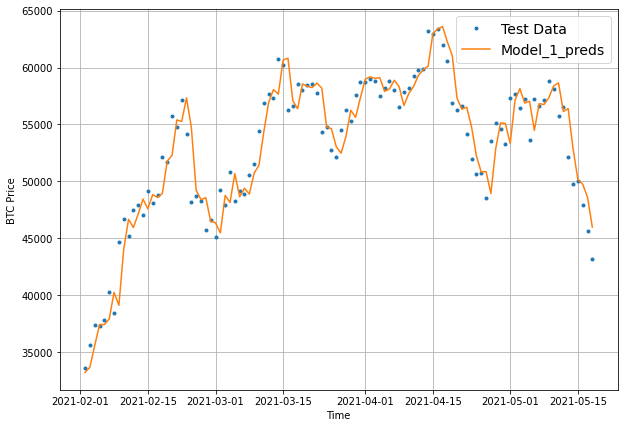

In [49]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [50]:
HORIZON = 1
WINDOW_SIZE = 30


In [51]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [52]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2205, 2205, 552, 552)

In [53]:
tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_2_history = model_2.fit(train_windows, train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint("model_2_dense")])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 495.4591 - mae: 495.4591 - mse: 1095898.7500

18/18 [==============================] - 2s 47ms/step - loss: 493.1748 - mae: 493.1748 - mse: 1087794.8750 - val_loss: 1734.1271 - val_mae: 1734.1271 - val_mse: 9257693.0000
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 334.7239 - mae: 334.7239 - mse: 511357.7812

18/18 [==============================] - 1s 50ms/step - loss: 334.9537 - mae: 334.9537 - mse: 505951.7188 - val_loss: 1582.2986 - val_mae: 1582.2986 - val_mse: 7254500.0000
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 251.7535 - mae: 251.7535 - mse: 316492.6562 - val_loss: 1591.3423 - val_mae: 1591.3423 - val_mse: 6549328.0000
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 268.7236 - mae: 268.7236 - mse: 327251.2188

18/18 [==============================] - 1s 38ms/step - loss: 273.4633 - mae: 273.4633 - mse: 338130.9375 - val_loss: 1379.9039 - val_mae: 1379.9039 - val_mse: 5072372.0000
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 242.1656 - mae: 242.1656 - mse: 265905.0938

18/18 [==============================] - 1s 51ms/step - loss: 241.0923 - mae: 241.0923 - mse: 263747.2812 - val_loss: 1096.0942 - val_mae: 1096.0942 - val_mse: 3954504.0000
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 214.6956 - mae: 214.6956 - mse: 217492.3750 - val_loss: 1333.8607 - val_mae: 1333.8606 - val_mse: 5201748.5000
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 195.8181 - mae: 195.8181 - mse: 187690.0156

18/18 [==============================] - 1s 57ms/step - loss: 193.3775 - mae: 193.3775 - mse: 188159.9375 - val_loss: 1052.2023 - val_mae: 1052.2023 - val_mse: 3584902.0000
Epoch 8/100
12/18 [===================>..........] - ETA: 0s - loss: 176.4901 - mae: 176.4901 - mse: 184301.8281

18/18 [==============================] - 1s 50ms/step - loss: 173.3046 - mae: 173.3046 - mse: 166152.7812 - val_loss: 907.2321 - val_mae: 907.2321 - val_mse: 2787861.2500
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 183.3102 - mae: 183.3102 - mse: 169569.6406 - val_loss: 1082.0334 - val_mae: 1082.0334 - val_mse: 3756820.0000
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 188.3960 - mae: 188.3960 - mse: 165660.2344 - val_loss: 910.5584 - val_mae: 910.5584 - val_mse: 2798123.2500
Epoch 11/100
18/18 [==============================] - ETA: 0s - loss: 161.0722 - mae: 161.0722 - mse: 138429.4688

18/18 [==============================] - 1s 37ms/step - loss: 161.0722 - mae: 161.0722 - mse: 138429.4688 - val_loss: 868.9582 - val_mae: 868.9582 - val_mse: 2369300.5000
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 181.0742 - mae: 181.0742 - mse: 157218.8125 - val_loss: 935.9757 - val_mae: 935.9757 - val_mse: 2590927.2500
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 154.5188 - mae: 154.5188 - mse: 130579.6641 - val_loss: 1120.2102 - val_mae: 1120.2102 - val_mse: 3826029.2500
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 170.6482 - mae: 170.6482 - mse: 146930.2969

18/18 [==============================] - 1s 38ms/step - loss: 170.6482 - mae: 170.6482 - mse: 146930.2969 - val_loss: 862.1428 - val_mae: 862.1428 - val_mse: 2328074.7500
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 158.5955 - mae: 158.5955 - mse: 130480.4844 - val_loss: 874.0632 - val_mae: 874.0632 - val_mse: 2616361.0000
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 170.3618 - mae: 170.3618 - mse: 138625.0625 - val_loss: 1018.8256 - val_mae: 1018.8256 - val_mse: 2880259.7500
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 155.3769 - mae: 155.3769 - mse: 123894.3516 - val_loss: 978.5926 - val_mae: 978.5926 - val_mse: 2711493.5000
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 155.1765 - mae: 155.1765 - mse: 124422.0547 - val_loss: 1005.1455 - val_mae: 1005.1455 - val_mse: 2806939.5000
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 163.5825 - mae: 163

18/18 [==============================] - 1s 37ms/step - loss: 186.5218 - mae: 186.5218 - mse: 152527.7031 - val_loss: 860.3804 - val_mae: 860.3804 - val_mse: 2497594.5000
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 170.2013 - mae: 170.2013 - mse: 144457.8906 - val_loss: 917.1582 - val_mae: 917.1582 - val_mse: 2444084.7500
Epoch 22/100
15/18 [========================>.....] - ETA: 0s - loss: 165.2285 - mae: 165.2285 - mse: 129261.8359

18/18 [==============================] - 1s 41ms/step - loss: 159.8087 - mae: 159.8087 - mse: 121379.6094 - val_loss: 795.4576 - val_mae: 795.4576 - val_mse: 2050711.3750
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 154.7838 - mae: 154.7838 - mse: 119415.6719

18/18 [==============================] - 1s 37ms/step - loss: 154.9681 - mae: 154.9681 - mse: 120963.0625 - val_loss: 773.1898 - val_mae: 773.1898 - val_mse: 2001936.8750
Epoch 24/100
17/18 [===========================>..] - ETA: 0s - loss: 148.6328 - mae: 148.6328 - mse: 117732.2422

18/18 [==============================] - 1s 37ms/step - loss: 149.6578 - mae: 149.6578 - mse: 118695.1562 - val_loss: 757.7627 - val_mae: 757.7627 - val_mse: 1956961.1250
Epoch 25/100
18/18 [==============================] - 0s 7ms/step - loss: 166.8437 - mae: 166.8437 - mse: 130965.8438 - val_loss: 809.8784 - val_mae: 809.8784 - val_mse: 2064663.3750
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 146.1214 - mae: 146.1214 - mse: 107300.4219 - val_loss: 977.5482 - val_mae: 977.5482 - val_mse: 2993899.5000
Epoch 27/100
18/18 [==============================] - 0s 6ms/step - loss: 159.9171 - mae: 159.9171 - mse: 120917.0859 - val_loss: 760.6839 - val_mae: 760.6839 - val_mse: 1910020.8750
Epoch 28/100
18/18 [==============================] - 0s 6ms/step - loss: 146.5983 - mae: 146.5983 - mse: 110771.8359 - val_loss: 782.7885 - val_mae: 782.7885 - val_mse: 2098441.7500
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 146.7899 - mae: 146.789

18/18 [==============================] - 1s 37ms/step - loss: 147.4884 - mae: 147.4884 - mse: 109195.2734 - val_loss: 729.2458 - val_mae: 729.2458 - val_mse: 1831248.8750
Epoch 32/100
18/18 [==============================] - 0s 6ms/step - loss: 173.5228 - mae: 173.5228 - mse: 133782.5469 - val_loss: 769.4117 - val_mae: 769.4117 - val_mse: 1914547.7500
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 150.4182 - mae: 150.4182 - mse: 107750.9844 - val_loss: 732.1716 - val_mae: 732.1716 - val_mse: 1844156.5000
Epoch 34/100
16/18 [=========================>....] - ETA: 0s - loss: 141.0035 - mae: 141.0035 - mse: 98039.0078

18/18 [==============================] - 1s 37ms/step - loss: 142.5944 - mae: 142.5944 - mse: 103629.3750 - val_loss: 717.0289 - val_mae: 717.0289 - val_mse: 1779175.5000
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 160.5199 - mae: 160.5199 - mse: 118858.9375 - val_loss: 928.3540 - val_mae: 928.3540 - val_mse: 2739253.7500
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 157.5784 - mae: 157.5784 - mse: 114497.0703 - val_loss: 965.9797 - val_mae: 965.9797 - val_mse: 2534492.0000
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 157.7798 - mae: 157.7798 - mse: 120250.8203 - val_loss: 873.4926 - val_mae: 873.4926 - val_mse: 2200849.7500
Epoch 38/100
18/18 [==============================] - 0s 6ms/step - loss: 148.6672 - mae: 148.6672 - mse: 107374.2578 - val_loss: 773.2728 - val_mae: 773.2728 - val_mse: 2064486.0000
Epoch 39/100
18/18 [==============================] - 0s 6ms/step - loss: 136.2227 - mae: 136.222

18/18 [==============================] - 1s 37ms/step - loss: 133.5469 - mae: 133.5469 - mse: 92147.3438 - val_loss: 705.7933 - val_mae: 705.7933 - val_mse: 1729904.5000
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 138.8007 - mae: 138.8007 - mse: 99358.1172 - val_loss: 707.5779 - val_mae: 707.5779 - val_mse: 1718991.7500
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 142.2060 - mae: 142.2060 - mse: 100766.6484 - val_loss: 727.9276 - val_mae: 727.9276 - val_mse: 1734484.2500
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 134.5483 - mae: 134.5483 - mse: 97430.1641 - val_loss: 785.7275 - val_mae: 785.7275 - val_mse: 2049906.5000
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 147.0938 - mae: 147.0938 - mse: 109913.5469 - val_loss: 754.7128 - val_mae: 754.7128 - val_mse: 1937022.8750
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 132.5840 - mae: 132.5840 -

18/18 [==============================] - 1s 47ms/step - loss: 160.1228 - mae: 160.1228 - mse: 117134.7578 - val_loss: 704.0238 - val_mae: 704.0238 - val_mse: 1688064.0000
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 152.1912 - mae: 152.1912 - mse: 109777.3672 - val_loss: 761.5195 - val_mae: 761.5195 - val_mse: 1974978.7500
Epoch 50/100
12/18 [===================>..........] - ETA: 0s - loss: 133.7975 - mae: 133.7975 - mse: 94226.3359

18/18 [==============================] - 1s 57ms/step - loss: 137.7747 - mae: 137.7747 - mse: 94084.2812 - val_loss: 697.1871 - val_mae: 697.1871 - val_mse: 1698935.3750
Epoch 51/100
18/18 [==============================] - 0s 8ms/step - loss: 141.4781 - mae: 141.4781 - mse: 101606.1250 - val_loss: 779.8304 - val_mae: 779.8304 - val_mse: 2015423.2500
Epoch 52/100
14/18 [======================>.......] - ETA: 0s - loss: 139.1402 - mae: 139.1402 - mse: 101400.9844

18/18 [==============================] - 1s 64ms/step - loss: 136.1340 - mae: 136.1340 - mse: 95767.1328 - val_loss: 680.8868 - val_mae: 680.8868 - val_mse: 1604793.7500
Epoch 53/100
15/18 [========================>.....] - ETA: 0s - loss: 128.8335 - mae: 128.8335 - mse: 89175.9766 

18/18 [==============================] - 1s 38ms/step - loss: 129.5842 - mae: 129.5842 - mse: 88527.6328 - val_loss: 677.8993 - val_mae: 677.8993 - val_mse: 1591311.5000
Epoch 54/100
15/18 [========================>.....] - ETA: 0s - loss: 133.3845 - mae: 133.3845 - mse: 87942.8438

18/18 [==============================] - 1s 38ms/step - loss: 133.3711 - mae: 133.3711 - mse: 88883.8203 - val_loss: 671.5651 - val_mae: 671.5651 - val_mse: 1563280.7500
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 120.3528 - mae: 120.3528 - mse: 79900.9453

18/18 [==============================] - 1s 39ms/step - loss: 124.1235 - mae: 124.1235 - mse: 84315.0312 - val_loss: 670.4110 - val_mae: 670.4110 - val_mse: 1533376.3750
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 133.5638 - mae: 133.5638 - mse: 92520.5000 - val_loss: 687.1194 - val_mae: 687.1194 - val_mse: 1663894.5000
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 126.4972 - mae: 126.4972 - mse: 85944.0000 - val_loss: 1003.1567 - val_mae: 1003.1567 - val_mse: 2579515.0000
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 130.8699 - mae: 130.8699 - mse: 88782.1172 - val_loss: 679.4567 - val_mae: 679.4567 - val_mse: 1611905.2500
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 136.2953 - mae: 136.2953 - mse: 89617.4062 - val_loss: 1333.5018 - val_mae: 1333.5018 - val_mse: 4009942.2500
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 156.3302 - mae: 156.3302

18/18 [==============================] - 1s 38ms/step - loss: 128.1788 - mae: 128.1788 - mse: 85880.4453 - val_loss: 666.4341 - val_mae: 666.4341 - val_mse: 1531895.6250
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 121.6810 - mae: 121.6810 - mse: 83130.7188 - val_loss: 720.7344 - val_mae: 720.7344 - val_mse: 1749195.3750
Epoch 66/100
17/18 [===========================>..] - ETA: 0s - loss: 132.6587 - mae: 132.6587 - mse: 87988.6562 

18/18 [==============================] - 1s 38ms/step - loss: 132.4209 - mae: 132.4209 - mse: 87725.8516 - val_loss: 659.7398 - val_mae: 659.7398 - val_mse: 1486501.7500
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 120.9738 - mae: 120.9738 - mse: 81752.3203 - val_loss: 670.5227 - val_mae: 670.5227 - val_mse: 1480239.7500
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 127.1311 - mae: 127.1311 - mse: 85297.4062 - val_loss: 768.1395 - val_mae: 768.1395 - val_mse: 1769906.3750
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 128.6856 - mae: 128.6856 - mse: 87123.4141 - val_loss: 1148.2988 - val_mae: 1148.2988 - val_mse: 3138008.2500
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 143.0924 - mae: 143.0924 - mse: 98414.7969 - val_loss: 1158.0190 - val_mae: 1158.0190 - val_mse: 3187366.7500
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 134.6862 - mae: 134.6862

18/18 [==============================] - 1s 41ms/step - loss: 134.2154 - mae: 134.2154 - mse: 88416.1328 - val_loss: 650.4728 - val_mae: 650.4728 - val_mse: 1418099.5000
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 120.2477 - mae: 120.2477 - mse: 81190.0547 - val_loss: 793.4720 - val_mae: 793.4720 - val_mse: 2012610.3750
Epoch 79/100
14/18 [======================>.......] - ETA: 0s - loss: 135.4802 - mae: 135.4802 - mse: 90675.9453

18/18 [==============================] - 1s 39ms/step - loss: 135.7442 - mae: 135.7442 - mse: 89104.0000 - val_loss: 645.2263 - val_mae: 645.2263 - val_mse: 1408365.3750
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 126.2181 - mae: 126.2181 - mse: 83725.0625 - val_loss: 921.7999 - val_mae: 921.7999 - val_mse: 2233279.7500
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 135.9896 - mae: 135.9896 - mse: 89527.6250 - val_loss: 821.6449 - val_mae: 821.6449 - val_mse: 2083571.7500
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 123.9397 - mae: 123.9397 - mse: 79874.2266 - val_loss: 778.8777 - val_mae: 778.8777 - val_mse: 1771532.5000
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 146.7316 - mae: 146.7316 - mse: 99154.2656 - val_loss: 888.8602 - val_mae: 888.8602 - val_mse: 2350711.5000
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 132.3878 - mae: 132.3878 - m

18/18 [==============================] - 1s 37ms/step - loss: 136.1076 - mae: 136.1076 - mse: 93993.8281 - val_loss: 645.0986 - val_mae: 645.0986 - val_mse: 1413610.5000
Epoch 96/100
10/18 [===============>..............] - ETA: 0s - loss: 129.9394 - mae: 129.9394 - mse: 88064.1406

18/18 [==============================] - 1s 58ms/step - loss: 128.8445 - mae: 128.8445 - mse: 82194.8359 - val_loss: 635.2751 - val_mae: 635.2751 - val_mse: 1360463.5000
Epoch 97/100
18/18 [==============================] - 0s 11ms/step - loss: 131.6861 - mae: 131.6861 - mse: 86702.4219 - val_loss: 673.7457 - val_mae: 673.7457 - val_mse: 1544022.5000
Epoch 98/100
18/18 [==============================] - 0s 8ms/step - loss: 119.1903 - mae: 119.1903 - mse: 78701.0938 - val_loss: 638.8582 - val_mae: 638.8582 - val_mse: 1380273.8750
Epoch 99/100
18/18 [==============================] - 0s 8ms/step - loss: 116.0399 - mae: 116.0399 - mse: 75079.7578 - val_loss: 636.7723 - val_mae: 636.7723 - val_mse: 1400059.2500
Epoch 100/100
18/18 [==============================] - 0s 8ms/step - loss: 134.1735 - mae: 134.1735 - mse: 84374.3047 - val_loss: 796.6169 - val_mae: 796.6169 - val_mse: 1956836.6250


In [54]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 796.6168 - mae: 796.6168 - mse: 1956835.7500


[796.6168212890625, 796.6168212890625, 1956835.75]

In [55]:
# Load in the best performing model and evaluate 
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 635.2751 - mae: 635.2751 - mse: 1360463.5000


[635.2750854492188, 635.2750854492188, 1360463.5]

In [56]:
# get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [57]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 635.2751,
 'mse': 1360463.6,
 'rmse': 1166.3892,
 'mape': 2.8911278,
 'mase': 1.1104671}

In [58]:
model_1_results

{'mae': 568.77673,
 'mse': 1167764.5,
 'rmse': 1080.6315,
 'mape': 2.5534422,
 'mase': 0.9991832}

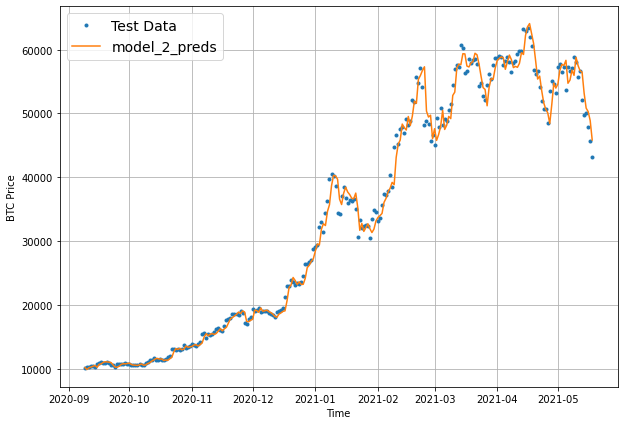

In [59]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)


In [60]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices,
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [61]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_labels,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

In [62]:
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_3_history = model_3.fit(train_windows, train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint("model_3_dense")])

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 2570.1897 - mae: 2570.1897 - mse: 18478360.0000 

18/18 [==============================] - 2s 48ms/step - loss: 2443.5269 - mae: 2443.5269 - mse: 17049186.0000 - val_loss: 9068.5771 - val_mae: 9068.5771 - val_mse: 180383184.0000
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 734.2712 - mae: 734.2712 - mse: 2190510.0000  

18/18 [==============================] - 1s 37ms/step - loss: 729.1510 - mae: 729.1510 - mse: 2169373.7500 - val_loss: 1636.4619 - val_mae: 1636.4619 - val_mse: 7469012.5000
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 218.1006 - mae: 218.1006 - mse: 203805.0625

18/18 [==============================] - 1s 54ms/step - loss: 218.1006 - mae: 218.1006 - mse: 203805.0625 - val_loss: 823.6973 - val_mae: 823.6973 - val_mse: 2134663.5000
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 144.6670 - mae: 144.6670 - mse: 107002.0156

18/18 [==============================] - 1s 38ms/step - loss: 144.3365 - mae: 144.3365 - mse: 106325.2578 - val_loss: 737.6309 - val_mae: 737.6309 - val_mse: 1864132.2500
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 132.7427 - mae: 132.7427 - mse: 96868.2812 

18/18 [==============================] - 1s 38ms/step - loss: 132.9136 - mae: 132.9136 - mse: 96735.4453 - val_loss: 702.6198 - val_mae: 702.6198 - val_mse: 1689052.0000
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 127.0172 - mae: 127.0172 - mse: 89697.0391

18/18 [==============================] - 1s 39ms/step - loss: 126.8669 - mae: 126.8669 - mse: 89513.0312 - val_loss: 683.6024 - val_mae: 683.6024 - val_mse: 1603312.2500
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 126.0902 - mae: 126.0902 - mse: 88379.4766

18/18 [==============================] - 1s 38ms/step - loss: 124.5725 - mae: 124.5725 - mse: 86134.6875 - val_loss: 666.6645 - val_mae: 666.6645 - val_mse: 1535938.0000
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 122.6933 - mae: 122.6933 - mse: 83351.8594 - val_loss: 682.9153 - val_mae: 682.9153 - val_mse: 1530998.1250
Epoch 9/100
17/18 [===========================>..] - ETA: 0s - loss: 121.6509 - mae: 121.6509 - mse: 80418.3516

18/18 [==============================] - 1s 37ms/step - loss: 121.7458 - mae: 121.7458 - mse: 80417.5781 - val_loss: 654.6358 - val_mae: 654.6358 - val_mse: 1443666.8750
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 117.1581 - mae: 117.1581 - mse: 74546.1875

18/18 [==============================] - 1s 37ms/step - loss: 118.0092 - mae: 118.0092 - mse: 76360.9844 - val_loss: 620.5000 - val_mae: 620.5000 - val_mse: 1331928.0000
Epoch 11/100
17/18 [===========================>..] - ETA: 0s - loss: 113.9322 - mae: 113.9322 - mse: 72207.9297

18/18 [==============================] - 1s 37ms/step - loss: 114.4365 - mae: 114.4365 - mse: 72947.6328 - val_loss: 605.4914 - val_mae: 605.4914 - val_mse: 1263292.2500
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1326 - mae: 111.1326 - mse: 68394.9609 - val_loss: 605.5231 - val_mae: 605.5231 - val_mse: 1228676.6250
Epoch 13/100
13/18 [====================>.........] - ETA: 0s - loss: 106.7591 - mae: 106.7591 - mse: 65356.7031

18/18 [==============================] - 1s 37ms/step - loss: 108.0703 - mae: 108.0703 - mse: 64231.5547 - val_loss: 570.5917 - val_mae: 570.5917 - val_mse: 1107992.0000
Epoch 14/100
15/18 [========================>.....] - ETA: 0s - loss: 100.0041 - mae: 100.0041 - mse: 55575.0117

18/18 [==============================] - 1s 54ms/step - loss: 103.6203 - mae: 103.6203 - mse: 59600.4023 - val_loss: 553.1339 - val_mae: 553.1339 - val_mse: 1018813.1875
Epoch 15/100
13/18 [====================>.........] - ETA: 0s - loss: 99.8873 - mae: 99.8873 - mse: 56803.8984

18/18 [==============================] - 1s 56ms/step - loss: 98.2073 - mae: 98.2073 - mse: 53880.9336 - val_loss: 526.1197 - val_mae: 526.1197 - val_mse: 930903.7500
Epoch 16/100
13/18 [====================>.........] - ETA: 0s - loss: 105.7175 - mae: 105.7175 - mse: 60002.7773

18/18 [==============================] - 1s 52ms/step - loss: 97.3676 - mae: 97.3676 - mse: 51444.2852 - val_loss: 498.3372 - val_mae: 498.3372 - val_mse: 839515.4375
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 91.2435 - mae: 91.2435 - mse: 45945.0273 - val_loss: 501.3963 - val_mae: 501.3963 - val_mse: 807861.7500
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 87.5268 - mae: 87.5268 - mse: 42106.5195

18/18 [==============================] - 1s 38ms/step - loss: 87.2875 - mae: 87.2875 - mse: 41904.1367 - val_loss: 453.0203 - val_mae: 453.0203 - val_mse: 688220.0625
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 82.4004 - mae: 82.4004 - mse: 37967.2383 - val_loss: 454.0827 - val_mae: 454.0827 - val_mse: 666136.7500
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 79.3062 - mae: 79.3062 - mse: 34946.2109

18/18 [==============================] - 1s 38ms/step - loss: 79.7955 - mae: 79.7955 - mse: 35526.8164 - val_loss: 416.5109 - val_mae: 416.5109 - val_mse: 577935.0625
Epoch 21/100
17/18 [===========================>..] - ETA: 0s - loss: 75.9579 - mae: 75.9579 - mse: 31979.1797

18/18 [==============================] - 1s 65ms/step - loss: 75.8828 - mae: 75.8828 - mse: 31935.8867 - val_loss: 391.8576 - val_mae: 391.8576 - val_mse: 516121.5000
Epoch 22/100
18/18 [==============================] - 0s 16ms/step - loss: 72.5201 - mae: 72.5201 - mse: 29565.2383 - val_loss: 412.3884 - val_mae: 412.3884 - val_mse: 534188.5000
Epoch 23/100
15/18 [========================>.....] - ETA: 0s - loss: 72.7591 - mae: 72.7591 - mse: 30139.9258

18/18 [==============================] - 1s 57ms/step - loss: 71.1324 - mae: 71.1324 - mse: 28411.5840 - val_loss: 365.0711 - val_mae: 365.0711 - val_mse: 446679.5938
Epoch 24/100
15/18 [========================>.....] - ETA: 0s - loss: 68.1578 - mae: 68.1578 - mse: 25800.5391

18/18 [==============================] - 1s 83ms/step - loss: 67.8331 - mae: 67.8331 - mse: 25599.5703 - val_loss: 339.3318 - val_mae: 339.3318 - val_mse: 396375.8750
Epoch 25/100
18/18 [==============================] - 0s 7ms/step - loss: 63.4646 - mae: 63.4646 - mse: 23797.6973 - val_loss: 347.3209 - val_mae: 347.3209 - val_mse: 407231.8125
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 61.7689 - mae: 61.7689 - mse: 22236.5664 - val_loss: 351.6208 - val_mae: 351.6208 - val_mse: 397114.4375
Epoch 27/100
17/18 [===========================>..] - ETA: 0s - loss: 61.8043 - mae: 61.8043 - mse: 22108.4648

18/18 [==============================] - 1s 38ms/step - loss: 61.4416 - mae: 61.4416 - mse: 21915.3535 - val_loss: 332.9225 - val_mae: 332.9225 - val_mse: 372932.0312
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 60.2044 - mae: 60.2044 - mse: 21357.3555

18/18 [==============================] - 1s 38ms/step - loss: 59.1903 - mae: 59.1903 - mse: 20612.6875 - val_loss: 313.5291 - val_mae: 313.5291 - val_mse: 333505.9062
Epoch 29/100
17/18 [===========================>..] - ETA: 0s - loss: 56.7547 - mae: 56.7547 - mse: 19335.9902

18/18 [==============================] - 1s 39ms/step - loss: 56.6022 - mae: 56.6022 - mse: 19224.1465 - val_loss: 297.2264 - val_mae: 297.2264 - val_mse: 305583.8750
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 56.6060 - mae: 56.6060 - mse: 19139.0996 - val_loss: 319.0938 - val_mae: 319.0938 - val_mse: 330601.8750
Epoch 31/100
17/18 [===========================>..] - ETA: 0s - loss: 57.2018 - mae: 57.2018 - mse: 18599.1113

18/18 [==============================] - 1s 37ms/step - loss: 57.3107 - mae: 57.3107 - mse: 18579.8398 - val_loss: 288.7975 - val_mae: 288.7975 - val_mse: 286093.0000
Epoch 32/100
16/18 [=========================>....] - ETA: 0s - loss: 56.5194 - mae: 56.5194 - mse: 19001.0820

18/18 [==============================] - 1s 38ms/step - loss: 55.8227 - mae: 55.8227 - mse: 18327.7188 - val_loss: 281.3507 - val_mae: 281.3507 - val_mse: 270607.5312
Epoch 33/100
16/18 [=========================>....] - ETA: 0s - loss: 53.7341 - mae: 53.7341 - mse: 17186.9160

18/18 [==============================] - 1s 39ms/step - loss: 53.8562 - mae: 53.8562 - mse: 17111.3066 - val_loss: 276.9252 - val_mae: 276.9252 - val_mse: 265132.9062
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 52.4183 - mae: 52.4183 - mse: 16511.7402

18/18 [==============================] - 1s 56ms/step - loss: 52.4183 - mae: 52.4183 - mse: 16511.7402 - val_loss: 275.0069 - val_mae: 275.0069 - val_mse: 254668.7812
Epoch 35/100
18/18 [==============================] - 0s 8ms/step - loss: 51.6011 - mae: 51.6011 - mse: 15718.3906 - val_loss: 278.4014 - val_mae: 278.4014 - val_mse: 254653.3281
Epoch 36/100
18/18 [==============================] - 0s 9ms/step - loss: 49.6465 - mae: 49.6465 - mse: 15003.3408 - val_loss: 284.3459 - val_mae: 284.3459 - val_mse: 266474.2188
Epoch 37/100
18/18 [==============================] - 0s 8ms/step - loss: 49.4819 - mae: 49.4819 - mse: 14600.8701 - val_loss: 288.4409 - val_mae: 288.4409 - val_mse: 268958.4375
Epoch 38/100
12/18 [===================>..........] - ETA: 0s - loss: 49.7919 - mae: 49.7919 - mse: 13173.8086

18/18 [==============================] - 1s 56ms/step - loss: 50.7217 - mae: 50.7217 - mse: 14907.2471 - val_loss: 261.6523 - val_mae: 261.6523 - val_mse: 233423.0781
Epoch 39/100
17/18 [===========================>..] - ETA: 0s - loss: 46.9610 - mae: 46.9610 - mse: 13490.1211

18/18 [==============================] - 1s 38ms/step - loss: 46.8182 - mae: 46.8182 - mse: 13386.3496 - val_loss: 252.8118 - val_mae: 252.8118 - val_mse: 222033.3281
Epoch 40/100
17/18 [===========================>..] - ETA: 0s - loss: 46.1907 - mae: 46.1907 - mse: 12881.2393

18/18 [==============================] - 1s 37ms/step - loss: 46.4135 - mae: 46.4135 - mse: 13007.3916 - val_loss: 247.0315 - val_mae: 247.0315 - val_mse: 211378.0625
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 46.5169 - mae: 46.5169 - mse: 12881.0547 - val_loss: 251.4785 - val_mae: 251.4785 - val_mse: 210325.1875
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 45.3232 - mae: 45.3232 - mse: 12394.4414 - val_loss: 253.3517 - val_mae: 253.3517 - val_mse: 208425.2188
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 45.7534 - mae: 45.7534 - mse: 12227.1348 - val_loss: 248.5145 - val_mae: 248.5145 - val_mse: 200421.6094
Epoch 44/100
17/18 [===========================>..] - ETA: 0s - loss: 46.7235 - mae: 46.7235 - mse: 12212.7070

18/18 [==============================] - 1s 36ms/step - loss: 46.7101 - mae: 46.7101 - mse: 12163.3584 - val_loss: 242.9077 - val_mae: 242.9077 - val_mse: 194772.9688
Epoch 45/100
17/18 [===========================>..] - ETA: 0s - loss: 45.7247 - mae: 45.7247 - mse: 12104.6221

18/18 [==============================] - 1s 36ms/step - loss: 45.5067 - mae: 45.5067 - mse: 12006.9531 - val_loss: 229.7589 - val_mae: 229.7589 - val_mse: 178486.2031
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 42.2459 - mae: 42.2459 - mse: 10749.2324 - val_loss: 234.8286 - val_mae: 234.8286 - val_mse: 184374.2500
Epoch 47/100
16/18 [=========================>....] - ETA: 0s - loss: 42.7795 - mae: 42.7795 - mse: 10789.1475

18/18 [==============================] - 1s 38ms/step - loss: 42.7188 - mae: 42.7188 - mse: 10689.3506 - val_loss: 221.3763 - val_mae: 221.3763 - val_mse: 164295.0312
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 40.5768 - mae: 40.5768 - mse: 10128.8115 - val_loss: 233.3431 - val_mae: 233.3431 - val_mse: 179583.4375
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 41.0453 - mae: 41.0453 - mse: 9885.6006 - val_loss: 223.2306 - val_mae: 223.2306 - val_mse: 161571.6406
Epoch 50/100
16/18 [=========================>....] - ETA: 0s - loss: 39.6135 - mae: 39.6135 - mse: 9492.0488

18/18 [==============================] - 1s 37ms/step - loss: 39.3960 - mae: 39.3960 - mse: 9242.5693 - val_loss: 209.4845 - val_mae: 209.4846 - val_mse: 149619.5938
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 37.9656 - mae: 37.9656 - mse: 8854.5771 - val_loss: 210.4513 - val_mae: 210.4513 - val_mse: 145903.6406
Epoch 52/100
18/18 [==============================] - ETA: 0s - loss: 37.2174 - mae: 37.2174 - mse: 8573.0439

18/18 [==============================] - 1s 37ms/step - loss: 37.2174 - mae: 37.2174 - mse: 8573.0439 - val_loss: 202.3314 - val_mae: 202.3314 - val_mse: 137661.0781
Epoch 53/100
16/18 [=========================>....] - ETA: 0s - loss: 38.5903 - mae: 38.5903 - mse: 8696.0752

18/18 [==============================] - 1s 52ms/step - loss: 38.3700 - mae: 38.3700 - mse: 8522.6758 - val_loss: 198.7290 - val_mae: 198.7290 - val_mse: 131981.2344
Epoch 54/100
16/18 [=========================>....] - ETA: 0s - loss: 37.8369 - mae: 37.8369 - mse: 8273.3125

18/18 [==============================] - 1s 40ms/step - loss: 37.4777 - mae: 37.4777 - mse: 8135.9956 - val_loss: 197.7595 - val_mae: 197.7595 - val_mse: 129106.3828
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 35.4453 - mae: 35.4453 - mse: 7604.1636 - val_loss: 199.2031 - val_mae: 199.2031 - val_mse: 129026.5000
Epoch 56/100
17/18 [===========================>..] - ETA: 0s - loss: 35.3204 - mae: 35.3204 - mse: 7374.9414

18/18 [==============================] - 1s 40ms/step - loss: 35.0801 - mae: 35.0801 - mse: 7304.4790 - val_loss: 191.5994 - val_mae: 191.5994 - val_mse: 121671.2891
Epoch 57/100
18/18 [==============================] - ETA: 0s - loss: 34.8775 - mae: 34.8775 - mse: 7198.9409

18/18 [==============================] - 1s 38ms/step - loss: 34.8775 - mae: 34.8775 - mse: 7198.9409 - val_loss: 190.2811 - val_mae: 190.2811 - val_mse: 117075.3984
Epoch 58/100
17/18 [===========================>..] - ETA: 0s - loss: 33.6260 - mae: 33.6260 - mse: 6843.1460

18/18 [==============================] - 1s 36ms/step - loss: 33.5768 - mae: 33.5768 - mse: 6811.9199 - val_loss: 178.4468 - val_mae: 178.4468 - val_mse: 108406.9922
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 32.7842 - mae: 32.7842 - mse: 6431.2744 - val_loss: 187.6631 - val_mae: 187.6631 - val_mse: 112143.2188
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 32.4678 - mae: 32.4678 - mse: 6325.6807 - val_loss: 188.1476 - val_mae: 188.1476 - val_mse: 115501.0781
Epoch 61/100
14/18 [======================>.......] - ETA: 0s - loss: 33.5448 - mae: 33.5448 - mse: 6635.9219

18/18 [==============================] - 1s 38ms/step - loss: 32.0567 - mae: 32.0567 - mse: 6041.7412 - val_loss: 173.5369 - val_mae: 173.5369 - val_mse: 99791.4922
Epoch 62/100
15/18 [========================>.....] - ETA: 0s - loss: 32.6802 - mae: 32.6802 - mse: 6241.1011 

18/18 [==============================] - 1s 59ms/step - loss: 31.7065 - mae: 31.7065 - mse: 5939.4087 - val_loss: 162.8457 - val_mae: 162.8457 - val_mse: 89187.5156
Epoch 63/100
18/18 [==============================] - 0s 8ms/step - loss: 30.3743 - mae: 30.3743 - mse: 5539.5474 - val_loss: 192.7313 - val_mae: 192.7313 - val_mse: 116792.0703
Epoch 64/100
18/18 [==============================] - 0s 8ms/step - loss: 31.8908 - mae: 31.8908 - mse: 5771.1421 - val_loss: 190.5411 - val_mae: 190.5411 - val_mse: 106819.8438
Epoch 65/100
18/18 [==============================] - 0s 9ms/step - loss: 32.0568 - mae: 32.0568 - mse: 5594.6914 - val_loss: 193.1768 - val_mae: 193.1768 - val_mse: 110461.0312
Epoch 66/100
18/18 [==============================] - 0s 8ms/step - loss: 29.8095 - mae: 29.8095 - mse: 5113.3354 - val_loss: 163.1534 - val_mae: 163.1534 - val_mse: 86352.1172
Epoch 67/100
13/18 [====================>.........] - ETA: 0s - loss: 28.9788 - mae: 28.9788 - mse: 5017.2319

18/18 [==============================] - 1s 57ms/step - loss: 28.5703 - mae: 28.5703 - mse: 4823.5684 - val_loss: 152.8507 - val_mae: 152.8507 - val_mse: 80958.2031
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 27.6294 - mae: 27.6294 - mse: 4712.8877 - val_loss: 157.2229 - val_mae: 157.2229 - val_mse: 86849.5078
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 27.9027 - mae: 27.9027 - mse: 4616.2856 - val_loss: 161.5238 - val_mae: 161.5238 - val_mse: 83090.7266
Epoch 70/100
16/18 [=========================>....] - ETA: 0s - loss: 27.3377 - mae: 27.3377 - mse: 4403.4697

18/18 [==============================] - 1s 37ms/step - loss: 27.3489 - mae: 27.3489 - mse: 4405.9331 - val_loss: 150.3585 - val_mae: 150.3585 - val_mse: 73762.3047
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 26.0087 - mae: 26.0087 - mse: 4111.3735 - val_loss: 175.7984 - val_mae: 175.7984 - val_mse: 89611.0625
Epoch 72/100
17/18 [===========================>..] - ETA: 0s - loss: 26.8800 - mae: 26.8800 - mse: 4138.8228 

18/18 [==============================] - 1s 36ms/step - loss: 26.7813 - mae: 26.7813 - mse: 4107.5166 - val_loss: 137.5671 - val_mae: 137.5671 - val_mse: 63535.9844
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 24.5717 - mae: 24.5717 - mse: 3760.7324 - val_loss: 159.6396 - val_mae: 159.6396 - val_mse: 80913.5547
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 27.3723 - mae: 27.3723 - mse: 4066.2136 - val_loss: 147.5611 - val_mae: 147.5611 - val_mse: 67430.9219
Epoch 75/100
17/18 [===========================>..] - ETA: 0s - loss: 25.8594 - mae: 25.8594 - mse: 3693.0076

18/18 [==============================] - 1s 37ms/step - loss: 25.8584 - mae: 25.8584 - mse: 3680.1829 - val_loss: 134.5604 - val_mae: 134.5604 - val_mse: 59618.4766
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 25.2510 - mae: 25.2510 - mse: 3574.1914 - val_loss: 136.8247 - val_mae: 136.8247 - val_mse: 63005.3125
Epoch 77/100
16/18 [=========================>....] - ETA: 0s - loss: 24.2061 - mae: 24.2061 - mse: 3403.2432

18/18 [==============================] - 1s 39ms/step - loss: 24.2880 - mae: 24.2880 - mse: 3387.7046 - val_loss: 129.6530 - val_mae: 129.6530 - val_mse: 53679.3086
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 24.1720 - mae: 24.1720 - mse: 3306.0349 - val_loss: 138.1935 - val_mae: 138.1935 - val_mse: 58306.9375
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 22.7884 - mae: 22.7884 - mse: 3030.1389 - val_loss: 131.8077 - val_mae: 131.8077 - val_mse: 59549.1406
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 22.8793 - mae: 22.8793 - mse: 3121.4744 - val_loss: 151.5897 - val_mae: 151.5897 - val_mse: 63206.7578
Epoch 81/100
18/18 [==============================] - 0s 7ms/step - loss: 28.7330 - mae: 28.7330 - mse: 3803.3459 - val_loss: 157.0382 - val_mae: 157.0382 - val_mse: 77993.1328
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 25.3031 - mae: 25.3031 - mse: 3247.4062 - val_loss: 1

18/18 [==============================] - 1s 39ms/step - loss: 22.2809 - mae: 22.2809 - mse: 2759.7605 - val_loss: 108.5225 - val_mae: 108.5225 - val_mse: 41472.0156
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 20.7090 - mae: 20.7090 - mse: 2480.0251 - val_loss: 119.8625 - val_mae: 119.8625 - val_mse: 45301.4375
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 20.0644 - mae: 20.0644 - mse: 2389.2039 - val_loss: 125.8163 - val_mae: 125.8163 - val_mse: 49366.4219
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 21.2455 - mae: 21.2455 - mse: 2529.5557 - val_loss: 126.3737 - val_mae: 126.3737 - val_mse: 48904.5586
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 21.4455 - mae: 21.4455 - mse: 2419.9285 - val_loss: 117.4231 - val_mae: 117.4231 - val_mse: 41554.1875
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 25.2501 - mae: 25.2501 - mse: 2935.9739 - val_loss: 1

18/18 [==============================] - 1s 38ms/step - loss: 18.8509 - mae: 18.8509 - mse: 1961.2260 - val_loss: 96.5306 - val_mae: 96.5306 - val_mse: 32647.8477
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 19.5564 - mae: 19.5564 - mse: 1997.6266 - val_loss: 107.5941 - val_mae: 107.5941 - val_mse: 33470.2578
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 20.5923 - mae: 20.5923 - mse: 2015.7461 - val_loss: 139.7392 - val_mae: 139.7392 - val_mse: 53558.0781
Epoch 95/100
18/18 [==============================] - 0s 6ms/step - loss: 19.7203 - mae: 19.7203 - mse: 1948.6793 - val_loss: 98.2836 - val_mae: 98.2836 - val_mse: 31788.6543
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 16.4901 - mae: 16.4901 - mse: 1536.8287 - val_loss: 111.1064 - val_mae: 111.1064 - val_mse: 42617.8320
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 17.9918 - mae: 17.9918 - mse: 1710.3373 - val_loss: 133.2

In [63]:
# Evaluate model 3
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 114.8747 - mae: 114.8747 - mse: 37092.8438


[114.87468719482422, 114.87468719482422, 37092.84375]

In [64]:
# Load best version of model_3
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 96.5306 - mae: 96.5306 - mse: 32647.8477


[96.53060913085938, 96.53060913085938, 32647.84765625]

In [65]:
# Make predictions 
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:3]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[8767.917, 8808.652, 9036.397, 8704.919, 8732.097, 8747.713,
        8716.606],
       [8796.109, 9049.087, 8810.4  , 8765.027, 8675.923, 8669.757,
        8586.616],
       [9037.698, 8728.257, 8757.125, 8715.868, 8593.125, 8515.815,
        8531.196]], dtype=float32)>

In [66]:
# Evaluate model_3 results
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': array([ 25.527903 ,  44.19852  ,  34.083427 ,  23.335798 ,  25.184849 ,
         42.46673  ,  27.368374 ,  20.763533 ,  51.68499  ,  27.973982 ,
         22.834402 ,  36.383648 ,  26.398716 ,  34.313057 ,  38.563545 ,
         38.69036  ,  40.12214  ,  38.073174 ,  42.44245  ,  28.166782 ,
         25.706125 ,  27.45438  ,  19.683523 ,  19.455217 ,  34.212193 ,
         27.141602 ,  29.94601  ,  23.99156  ,  15.8912525,  23.85812  ,
         22.325544 ,  30.692312 ,  22.672922 ,  26.58252  ,  41.551758 ,
         57.58524  ,  64.49156  ,  57.108467 ,  49.134624 ,  55.313686 ,
         33.496304 ,  16.85498  ,  24.017927 ,  28.641043 ,  20.466518 ,
         20.012136 ,  25.444057 ,  32.061176 ,  25.444336 ,  17.74393  ,
         29.484724 ,  28.857212 ,  23.882185 ,  39.165386 ,  29.457937 ,
         23.725447 ,  43.5881   ,  38.50321  ,  20.620256 ,  27.848911 ,
         40.547573 ,  40.322613 ,  34.21066  ,  38.619072 ,  55.19566  ,
         34.101772 ,  37.9488   ,  50.211773

## Make our evaluation function work for larger horizons


In [67]:
# Create a function to evaluate model forecasts with various metrics
def evaluate_preds(y_true, y_pred):
  """
  Evaluates model predictions with various metrics.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A dictionary of evaluation metrics, including:
          - 'mae': mean absolute error
          - 'mse': mean squared error
          - 'rmse': root mean squared error
          - 'mape': mean absolute percentage error
          - 'mase': mean absolute scaled error
  """
  # Make sure float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [68]:
# Get model_3 results
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 96.53061,
 'mse': 32647.844,
 'rmse': 123.80097,
 'mape': 0.4617669,
 'mase': 0.17177083}

In [69]:
model_2_results

{'mae': 635.2751,
 'mse': 1360463.6,
 'rmse': 1166.3892,
 'mape': 2.8911278,
 'mase': 1.1104671}

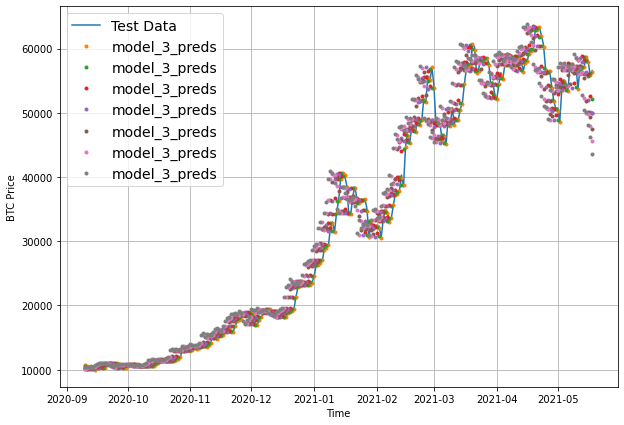

In [70]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

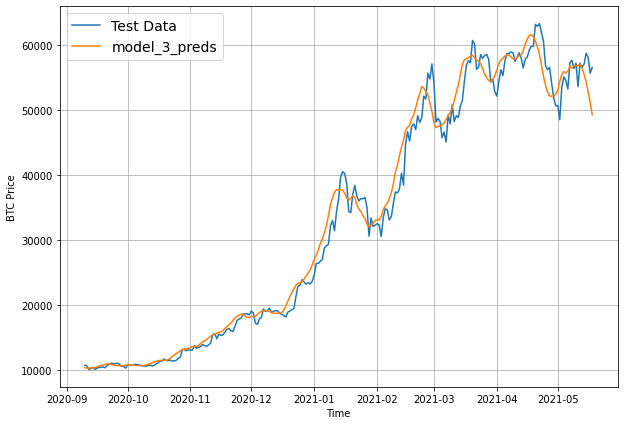

In [71]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

## Which of our models is performing the best so far?

So we've trained a few models, now let's compare them and see how they've gone...

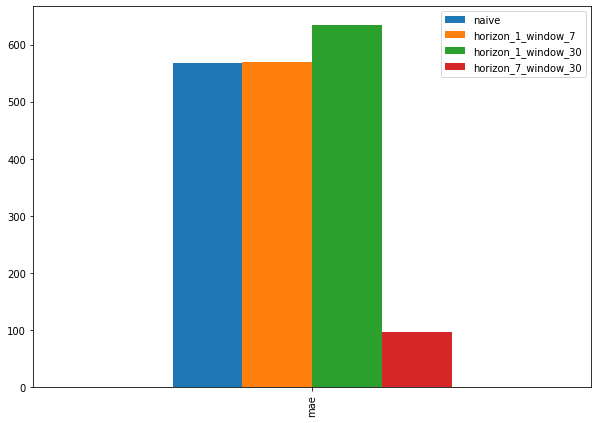

In [72]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");


> 🔑 **Note:** You might be wondering, why are the naive results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation i means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model will often get fairly good results.

> 📖 **Resources:** For more on how autocorrelation influences a model's predictions, see the arcticle [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls by Vegard Flovik.](https://www.kdnuggets.com/2020/03/machine-learning-time-series-forecasting-sequel.html)

## Model 4: Conv1D



In [73]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [74]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)


(2780, 2780)

In [75]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However, our data isn't in that shape yet...


In [76]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE,)

(7,)

In [77]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [78]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) #  add an extra dimension for `input_dim`


In [79]:
# Test out our lambda layer
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [80]:
# Create Conv1D
# Set random seed
tf.random.set_seed(42)

# Create model_4
model_4 = tf.keras.Sequential([
    expand_dims_layer,
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1d")

# Compile model
model_4.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=["mae"])


In [81]:
model_4.fit(train_windows, train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 2005.7266 - mae: 2005.7266  

18/18 [==============================] - 7s 76ms/step - loss: 1740.3168 - mae: 1740.3168 - val_loss: 1381.8530 - val_mae: 1381.8530
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 337.2045 - mae: 337.2045 - val_loss: 1625.3376 - val_mae: 1625.3376
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 235.3550 - mae: 235.3550

18/18 [==============================] - 1s 82ms/step - loss: 229.3990 - mae: 229.3990 - val_loss: 1091.7003 - val_mae: 1091.7003
Epoch 4/100
10/18 [===============>..............] - ETA: 0s - loss: 215.3042 - mae: 215.3042

18/18 [==============================] - 1s 61ms/step - loss: 198.2609 - mae: 198.2609 - val_loss: 1063.4080 - val_mae: 1063.4080
Epoch 5/100
15/18 [========================>.....] - ETA: 0s - loss: 196.7823 - mae: 196.7823

18/18 [==============================] - 1s 51ms/step - loss: 190.7678 - mae: 190.7678 - val_loss: 1060.4540 - val_mae: 1060.4540
Epoch 6/100
14/18 [======================>.......] - ETA: 0s - loss: 185.0625 - mae: 185.0625

18/18 [==============================] - 1s 51ms/step - loss: 186.2189 - mae: 186.2189 - val_loss: 1045.6766 - val_mae: 1045.6766
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 190.0352 - mae: 190.0352

18/18 [==============================] - 1s 52ms/step - loss: 185.1806 - mae: 185.1806 - val_loss: 1021.6484 - val_mae: 1021.6484
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 181.0324 - mae: 181.0324 - val_loss: 1023.6625 - val_mae: 1023.6625
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 177.9217 - mae: 177.9217 - val_loss: 1022.0517 - val_mae: 1022.0517
Epoch 10/100
14/18 [======================>.......] - ETA: 0s - loss: 171.5477 - mae: 171.5477

18/18 [==============================] - 1s 51ms/step - loss: 175.3511 - mae: 175.3511 - val_loss: 983.7108 - val_mae: 983.7108
Epoch 11/100
14/18 [======================>.......] - ETA: 0s - loss: 174.2923 - mae: 174.2923

18/18 [==============================] - 1s 54ms/step - loss: 172.1109 - mae: 172.1109 - val_loss: 955.4335 - val_mae: 955.4335
Epoch 12/100
18/18 [==============================] - 0s 8ms/step - loss: 170.1048 - mae: 170.1048 - val_loss: 1002.1935 - val_mae: 1002.1935
Epoch 13/100
14/18 [======================>.......] - ETA: 0s - loss: 166.6376 - mae: 166.6376

18/18 [==============================] - 1s 54ms/step - loss: 167.0833 - mae: 167.0833 - val_loss: 944.0258 - val_mae: 944.0258
Epoch 14/100
15/18 [========================>.....] - ETA: 0s - loss: 160.9530 - mae: 160.9530

18/18 [==============================] - 1s 70ms/step - loss: 162.7940 - mae: 162.7940 - val_loss: 932.1814 - val_mae: 932.1814
Epoch 15/100
18/18 [==============================] - 0s 7ms/step - loss: 163.0001 - mae: 163.0001 - val_loss: 952.7202 - val_mae: 952.7203
Epoch 16/100
14/18 [======================>.......] - ETA: 0s - loss: 158.2242 - mae: 158.2242

18/18 [==============================] - 1s 53ms/step - loss: 157.9858 - mae: 157.9858 - val_loss: 865.9584 - val_mae: 865.9584
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 153.6361 - mae: 153.6361 - val_loss: 904.0294 - val_mae: 904.0294
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 151.2966 - mae: 151.2966 - val_loss: 894.1920 - val_mae: 894.1920
Epoch 19/100
15/18 [========================>.....] - ETA: 0s - loss: 147.3866 - mae: 147.3866

18/18 [==============================] - 1s 53ms/step - loss: 147.4480 - mae: 147.4480 - val_loss: 828.4034 - val_mae: 828.4034
Epoch 20/100
14/18 [======================>.......] - ETA: 0s - loss: 148.1649 - mae: 148.1649

18/18 [==============================] - 1s 78ms/step - loss: 145.7180 - mae: 145.7180 - val_loss: 810.2198 - val_mae: 810.2198
Epoch 21/100
10/18 [===============>..............] - ETA: 0s - loss: 150.7471 - mae: 150.7471

18/18 [==============================] - 1s 74ms/step - loss: 143.1436 - mae: 143.1436 - val_loss: 778.1162 - val_mae: 778.1162
Epoch 22/100
12/18 [===================>..........] - ETA: 0s - loss: 152.4134 - mae: 152.4134

18/18 [==============================] - 1s 52ms/step - loss: 141.1237 - mae: 141.1237 - val_loss: 769.8598 - val_mae: 769.8599
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 136.0008 - mae: 136.0008 - val_loss: 777.5998 - val_mae: 777.5998
Epoch 24/100
15/18 [========================>.....] - ETA: 0s - loss: 136.0208 - mae: 136.0208

18/18 [==============================] - 1s 50ms/step - loss: 136.4285 - mae: 136.4285 - val_loss: 752.2252 - val_mae: 752.2252
Epoch 25/100
15/18 [========================>.....] - ETA: 0s - loss: 140.2763 - mae: 140.2763

18/18 [==============================] - 1s 50ms/step - loss: 136.1188 - mae: 136.1188 - val_loss: 734.0178 - val_mae: 734.0178
Epoch 26/100
15/18 [========================>.....] - ETA: 0s - loss: 135.1970 - mae: 135.1970

18/18 [==============================] - 1s 51ms/step - loss: 130.7757 - mae: 130.7757 - val_loss: 722.2402 - val_mae: 722.2402
Epoch 27/100
14/18 [======================>.......] - ETA: 0s - loss: 129.7460 - mae: 129.7460

18/18 [==============================] - 1s 69ms/step - loss: 128.6605 - mae: 128.6605 - val_loss: 705.1375 - val_mae: 705.1375
Epoch 28/100
15/18 [========================>.....] - ETA: 0s - loss: 124.6684 - mae: 124.6684

18/18 [==============================] - 1s 52ms/step - loss: 126.5434 - mae: 126.5434 - val_loss: 688.7635 - val_mae: 688.7635
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 123.7850 - mae: 123.7850 - val_loss: 695.2150 - val_mae: 695.2150
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 128.0875 - mae: 128.0875 - val_loss: 806.7719 - val_mae: 806.7719
Epoch 31/100
18/18 [==============================] - 0s 7ms/step - loss: 140.6186 - mae: 140.6186 - val_loss: 865.3670 - val_mae: 865.3670
Epoch 32/100
14/18 [======================>.......] - ETA: 0s - loss: 138.9145 - mae: 138.9145

18/18 [==============================] - 1s 53ms/step - loss: 135.3435 - mae: 135.3435 - val_loss: 663.1655 - val_mae: 663.1655
Epoch 33/100
13/18 [====================>.........] - ETA: 0s - loss: 127.8604 - mae: 127.8604

18/18 [==============================] - 1s 54ms/step - loss: 125.9477 - mae: 125.9477 - val_loss: 650.4886 - val_mae: 650.4886
Epoch 34/100
14/18 [======================>.......] - ETA: 0s - loss: 122.1664 - mae: 122.1664

18/18 [==============================] - 1s 52ms/step - loss: 118.9235 - mae: 118.9235 - val_loss: 644.1378 - val_mae: 644.1378
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 119.4178 - mae: 119.4178 - val_loss: 648.1932 - val_mae: 648.1932
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 126.6097 - mae: 126.6097 - val_loss: 718.6309 - val_mae: 718.6309
Epoch 37/100
14/18 [======================>.......] - ETA: 0s - loss: 122.0269 - mae: 122.0269

18/18 [==============================] - 1s 57ms/step - loss: 120.0201 - mae: 120.0201 - val_loss: 631.4270 - val_mae: 631.4270
Epoch 38/100
10/18 [===============>..............] - ETA: 0s - loss: 122.1100 - mae: 122.1100

18/18 [==============================] - 1s 83ms/step - loss: 117.0436 - mae: 117.0436 - val_loss: 625.8263 - val_mae: 625.8263
Epoch 39/100
10/18 [===============>..............] - ETA: 0s - loss: 118.5101 - mae: 118.5101

18/18 [==============================] - 1s 62ms/step - loss: 115.3084 - mae: 115.3084 - val_loss: 619.5674 - val_mae: 619.5674
Epoch 40/100
13/18 [====================>.........] - ETA: 0s - loss: 116.0289 - mae: 116.0289

18/18 [==============================] - 1s 50ms/step - loss: 115.1756 - mae: 115.1756 - val_loss: 615.3760 - val_mae: 615.3760
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 118.0901 - mae: 118.0901 - val_loss: 677.1941 - val_mae: 677.1941
Epoch 42/100
15/18 [========================>.....] - ETA: 0s - loss: 119.8012 - mae: 119.8012

18/18 [==============================] - 1s 51ms/step - loss: 121.9258 - mae: 121.9258 - val_loss: 608.0292 - val_mae: 608.0292
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 113.9589 - mae: 113.9589 - val_loss: 612.5981 - val_mae: 612.5981
Epoch 44/100
18/18 [==============================] - 0s 7ms/step - loss: 116.9396 - mae: 116.9396 - val_loss: 640.4170 - val_mae: 640.4170
Epoch 45/100
14/18 [======================>.......] - ETA: 0s - loss: 115.9915 - mae: 115.9915

18/18 [==============================] - 1s 51ms/step - loss: 118.9028 - mae: 118.9028 - val_loss: 602.7361 - val_mae: 602.7361
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 114.1363 - mae: 114.1363 - val_loss: 615.7977 - val_mae: 615.7977
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 116.0657 - mae: 116.0657 - val_loss: 700.8223 - val_mae: 700.8223
Epoch 48/100
18/18 [==============================] - 0s 7ms/step - loss: 114.5461 - mae: 114.5461 - val_loss: 626.8174 - val_mae: 626.8174
Epoch 49/100
12/18 [===================>..........] - ETA: 0s - loss: 119.9370 - mae: 119.9370

18/18 [==============================] - 1s 52ms/step - loss: 113.8544 - mae: 113.8544 - val_loss: 601.2531 - val_mae: 601.2531
Epoch 50/100
15/18 [========================>.....] - ETA: 0s - loss: 111.9152 - mae: 111.9152

18/18 [==============================] - 1s 52ms/step - loss: 113.3080 - mae: 113.3080 - val_loss: 595.7036 - val_mae: 595.7036
Epoch 51/100
15/18 [========================>.....] - ETA: 0s - loss: 112.4444 - mae: 112.4444

18/18 [==============================] - 1s 73ms/step - loss: 112.1443 - mae: 112.1443 - val_loss: 593.9917 - val_mae: 593.9917
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 113.2774 - mae: 113.2774 - val_loss: 605.2162 - val_mae: 605.2162
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 115.1930 - mae: 115.1930 - val_loss: 615.0487 - val_mae: 615.0487
Epoch 54/100
18/18 [==============================] - 0s 8ms/step - loss: 123.0340 - mae: 123.0340 - val_loss: 707.4259 - val_mae: 707.4259
Epoch 55/100
13/18 [====================>.........] - ETA: 0s - loss: 122.2006 - mae: 122.2006

18/18 [==============================] - 1s 50ms/step - loss: 114.7988 - mae: 114.7988 - val_loss: 589.9252 - val_mae: 589.9252
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 113.4114 - mae: 113.4114 - val_loss: 834.3079 - val_mae: 834.3079
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 136.5289 - mae: 136.5289 - val_loss: 625.8281 - val_mae: 625.8281
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 119.6885 - mae: 119.6885 - val_loss: 630.0849 - val_mae: 630.0849
Epoch 59/100
15/18 [========================>.....] - ETA: 0s - loss: 111.2939 - mae: 111.2939

18/18 [==============================] - 1s 51ms/step - loss: 110.3960 - mae: 110.3960 - val_loss: 589.2758 - val_mae: 589.2758
Epoch 60/100
15/18 [========================>.....] - ETA: 0s - loss: 111.8215 - mae: 111.8215

18/18 [==============================] - 1s 65ms/step - loss: 110.2345 - mae: 110.2345 - val_loss: 587.2417 - val_mae: 587.2417
Epoch 61/100
18/18 [==============================] - 0s 9ms/step - loss: 109.7411 - mae: 109.7411 - val_loss: 602.3229 - val_mae: 602.3229
Epoch 62/100
10/18 [===============>..............] - ETA: 0s - loss: 105.0028 - mae: 105.0028

18/18 [==============================] - 1s 82ms/step - loss: 111.0105 - mae: 111.0105 - val_loss: 581.2846 - val_mae: 581.2846
Epoch 63/100
18/18 [==============================] - 0s 12ms/step - loss: 110.6668 - mae: 110.6668 - val_loss: 612.6314 - val_mae: 612.6314
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 112.6265 - mae: 112.6265 - val_loss: 679.6332 - val_mae: 679.6332
Epoch 65/100
18/18 [==============================] - 0s 7ms/step - loss: 117.1032 - mae: 117.1032 - val_loss: 585.9369 - val_mae: 585.9369
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2875 - mae: 111.2875 - val_loss: 590.0994 - val_mae: 590.0994
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 108.6718 - mae: 108.6718 - val_loss: 598.0414 - val_mae: 598.0414
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 116.7128 - mae: 116.7128 - val_loss: 723.5392 - val_mae: 723.5392
Epoch 69/100
18/18 [===========

18/18 [==============================] - 1s 51ms/step - loss: 110.1773 - mae: 110.1773 - val_loss: 579.2425 - val_mae: 579.2425
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 109.2284 - mae: 109.2284 - val_loss: 585.4487 - val_mae: 585.4487
Epoch 74/100
15/18 [========================>.....] - ETA: 0s - loss: 109.3051 - mae: 109.3051

18/18 [==============================] - 1s 50ms/step - loss: 109.6327 - mae: 109.6327 - val_loss: 574.2114 - val_mae: 574.2114
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 109.0777 - mae: 109.0777 - val_loss: 584.2603 - val_mae: 584.2603
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 110.4024 - mae: 110.4024 - val_loss: 577.5901 - val_mae: 577.5901
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 110.6491 - mae: 110.6491 - val_loss: 590.7972 - val_mae: 590.7972
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 108.5469 - mae: 108.5469 - val_loss: 575.5813 - val_mae: 575.5813
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 109.2920 - mae: 109.2920 - val_loss: 600.8031 - val_mae: 600.8031
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 108.9855 - mae: 108.9855 - val_loss: 576.8710 - val_mae: 576.8710
Epoch 81/100
14/18 [============

18/18 [==============================] - 1s 53ms/step - loss: 107.8653 - mae: 107.8653 - val_loss: 570.5546 - val_mae: 570.5546
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 114.7560 - mae: 114.7560 - val_loss: 570.5877 - val_mae: 570.5877
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 112.4727 - mae: 112.4727 - val_loss: 675.9980 - val_mae: 675.9980
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 114.4252 - mae: 114.4252 - val_loss: 600.9155 - val_mae: 600.9155
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9161 - mae: 108.9161 - val_loss: 591.1351 - val_mae: 591.1351
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 109.2978 - mae: 109.2978 - val_loss: 630.2247 - val_mae: 630.2247
Epoch 87/100
15/18 [========================>.....] - ETA: 0s - loss: 108.3438 - mae: 108.3438

18/18 [==============================] - 1s 51ms/step - loss: 109.2043 - mae: 109.2043 - val_loss: 569.4839 - val_mae: 569.4839
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 108.4710 - mae: 108.4710 - val_loss: 589.2479 - val_mae: 589.2479
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 109.5868 - mae: 109.5868 - val_loss: 578.7461 - val_mae: 578.7461
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 106.9267 - mae: 106.9267 - val_loss: 623.3480 - val_mae: 623.3480
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 110.0258 - mae: 110.0258 - val_loss: 617.4809 - val_mae: 617.4809
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 110.7781 - mae: 110.7781 - val_loss: 569.9359 - val_mae: 569.9359
Epoch 93/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7393 - mae: 112.7393 - val_loss: 593.7751 - val_mae: 593.7751
Epoch 94/100
18/18 [============

18/18 [==============================] - 1s 51ms/step - loss: 107.1072 - mae: 107.1072 - val_loss: 567.3976 - val_mae: 567.3976
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 110.9023 - mae: 110.9023 - val_loss: 669.2040 - val_mae: 669.2040
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 110.5387 - mae: 110.5387 - val_loss: 568.2792 - val_mae: 568.2792
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 107.2849 - mae: 107.2849 - val_loss: 579.9789 - val_mae: 579.9789
Epoch 99/100
15/18 [========================>.....] - ETA: 0s - loss: 105.9098 - mae: 105.9098

18/18 [==============================] - 1s 69ms/step - loss: 108.1835 - mae: 108.1835 - val_loss: 566.3741 - val_mae: 566.3741
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 118.3089 - mae: 118.3089 - val_loss: 660.6885 - val_mae: 660.6885


In [82]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 660.6885 - mae: 660.6885


[660.6884765625, 660.6884765625]

In [84]:
# Load back in best performing Conv1D model and evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1d/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 566.3741 - mae: 566.3741


[566.3740844726562, 566.3740844726562]

In [85]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8876.329, 8776.105, 9005.438, 8808.489, 8734.332, 8718.197,
       8685.781, 8541.647, 8445.19 , 8521.344], dtype=float32)>

In [86]:
# Evaluate predictions
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)
model_4_results

{'mae': 566.37415,
 'mse': 1172689.2,
 'rmse': 1082.9077,
 'mape': 2.5417905,
 'mase': 0.9949625}

In [87]:
model_1_results

{'mae': 568.77673,
 'mse': 1167764.5,
 'rmse': 1080.6315,
 'mape': 2.5534422,
 'mase': 0.9991832}

## Model_5: RNN (LSTM)


In [92]:
tf.random.set_seed(42)

# Create LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

# Fit model
model_5_history = model_5.fit(train_windows, train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=0,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [93]:
# Evaluate model 5
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 643.3579


643.35791015625

In [94]:
# Load best performing model and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 589.9951


589.9951171875

In [96]:
model_5_preds = make_preds(model_5, test_windows)

18/18 [==============================] - 0s 2ms/step


In [98]:
model_5_results = evaluate_preds(tf.squeeze(test_labels, axis=1), model_5_preds)
model_5_results

{'mae': 589.9951,
 'mse': 1240201.4,
 'rmse': 1113.6433,
 'mape': 2.6485963,
 'mase': 1.036458}

In [99]:
model_1_results

{'mae': 568.77673,
 'mse': 1167764.5,
 'rmse': 1080.6315,
 'mape': 2.5534422,
 'mase': 0.9991832}